In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Add seeds
np.random.seed(2021)

### Creating training and validation from raw dataset

In [74]:
images_path = '../data/images/'
masks_path = '../data/masks/'

images = [img for img in os.listdir(images_path)]
masks = [mask for mask in os.listdir(masks_path)]

print(f'Number of Images: {len(images)}')
print(f'Number of Masks: {len(masks):>4}')

Number of Images: 743
Number of Masks:  890


The number of masks and images are not equal. So, we will find the respective pairs and discard the rest. After that we will create training and validation dataset.

In [77]:
common_filenames = list(set(images).intersection(masks))
np.random.shuffle(common_filenames)
split_ratio = 0.7
train_set = int(split_ratio*len(common_filenames))
test_set = len(common_filenames) - train_set


train_files = common_filenames[:train_set]
test_files = common_filenames[train_set:]

print(f'Images and Mask in Final Dataset: {len(common_filenames):>4}')
print(f'Train set: {train_set:>27}')
print(f'Test set: {test_set:>28}')

Images and Mask in Final Dataset:  743
Train set:                         520
Test set:                          223


In [ ]:
class gunsAndBoxes

### Displaying images with corresponding mask

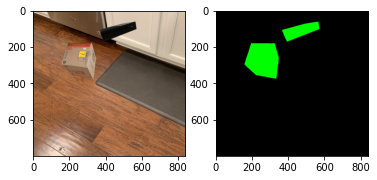

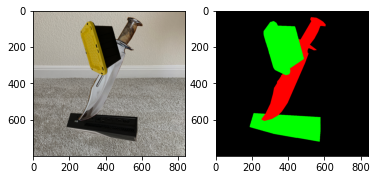

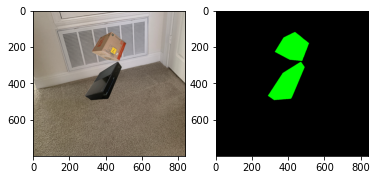

In [78]:
for i in range(3):
    plt.figure()
    
    # Original Image
    plt.subplot(1,2,1)
    img = Image.open(images_path+train_files[i])
    plt.imshow(img)
    
    # Segmented Image
    plt.subplot(1,2,2)
    mask = Image.open(masks_path+train_files[i])
    plt.imshow(mask)